# Pobranie danych

In [1]:
#download and unzip all files from kaggle - requires integration with kaggle
#uncomment to run

# !kaggle competitions download -c walmart-recruiting-store-sales-forecasting -p data
# !unzip data/walmart-recruiting-store-sales-forecasting.zip -d data/tmp
# !rm -r data/store-sales
# !unzip data/tmp/features.csv.zip -d data/store-sales
# !unzip data/tmp/sampleSubmission.csv.zip -d data/store-sales
# !unzip data/tmp/train.csv.zip -d data/store-sales
# !unzip data/tmp/test.csv.zip -d data/store-sales
# !cp data/tmp/stores.csv data/store-sales/stores.csv
# !rm -r data/tmp

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
features = pd.read_csv("data/store-sales/features.csv")
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [4]:
stores = pd.read_csv("data/store-sales/stores.csv")
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [5]:
data = pd.read_csv("data/store-sales/train.csv")
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


# Wstępna analiza

In [6]:
features["Store"].value_counts().head()

1     182
24    182
26    182
27    182
28    182
Name: Store, dtype: int64

In [7]:
print(features["Date"].min())
print(features["Date"].max())

2010-02-05
2013-07-26


Tabela `features` zawiera dane dla 45 sklepów, dla każdego z nich zawiera 182 rekordy gdzie każdy rekord to dane z danego tygodnia, dla każdego sklepu dane pochodzą z tych samych tygodni od 2010-02-05 do 2013-07-26. Kolumna `IsHoliday` jest skorelowana z datą.

In [8]:
stores["Type"].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

<Axes: xlabel='Store', ylabel='Size'>

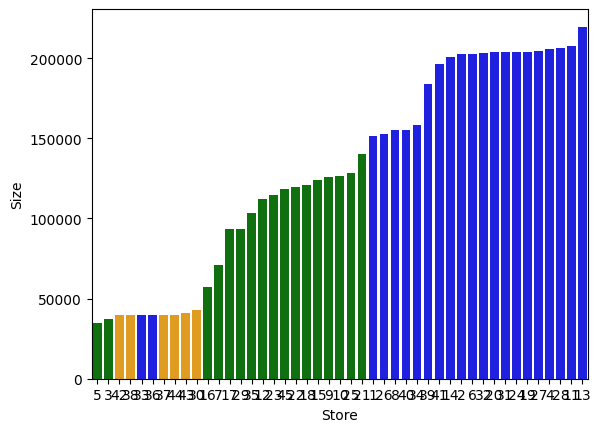

In [9]:
map_type_to_color = {
    "A": "blue",
    "B": "green",
    "C": "orange",
}

plot_data = stores.sort_values(by=["Size"])
plot_data["Store"] = plot_data["Store"].astype(str)
plot_data["Color"] = plot_data["Type"].apply(lambda t: map_type_to_color[t])
sns.barplot(data=plot_data, x="Store", y="Size", palette=plot_data["Color"])

Tabela `stores` zawiera dane dla tych samych 45 sklepów. Podaje szczegóły na temat sklepu czyli typ (`A`, `B`, `C`) oraz wielkość.

<Axes: xlabel='Store', ylabel='count'>

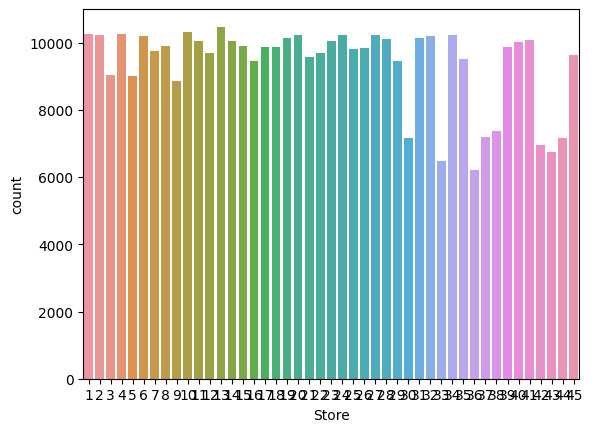

In [10]:
sns.countplot(data=data, x="Store")

<Axes: xlabel='Store', ylabel='Dept quantity'>

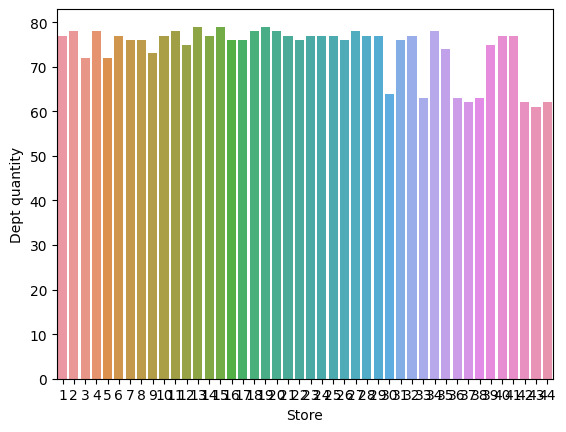

In [11]:
plot_data = pd.DataFrame({"Store": np.arange(1, 45)})
plot_data["Dept quantity"] = plot_data["Store"].apply(lambda n: len(data.loc[data["Store"] == n]["Dept"].unique()))
sns.barplot(data=plot_data, x="Store", y="Dept quantity")

Tabela z danymi `data` zawiera dane o wynikach sprzedaży, każdy wiersz to numer sklepu, dział sklepu(od 1 do 99), data, zysk i informacja czy było święto.

# Prophet

In [12]:
from prophet import Prophet

In [13]:
# example for store 1 and dept 1
train_data = data[(data["Store"] == 1) & (data["Dept"] == 1)][["Date", "Weekly_Sales", "IsHoliday"]]
train_data.columns = ["ds", "y", "h"]
holidays = train_data.loc[train_data["h"]][["ds"]]
holidays["holiday"] = "holiday"
holidays

,ds,holiday
1,2010-02-12,holiday
31,2010-09-10,holiday
42,2010-11-26,holiday
47,2010-12-31,holiday
53,2011-02-11,holiday
83,2011-09-09,holiday
94,2011-11-25,holiday
99,2011-12-30,holiday
105,2012-02-10,holiday
135,2012-09-07,holiday


In [14]:
train_data

,ds,y,h
0,2010-02-05,24924.50,False
1,2010-02-12,46039.49,True
2,2010-02-19,41595.55,False
3,2010-02-26,19403.54,False
4,2010-03-05,21827.90,False
...,...,...,...
138,2012-09-28,18947.81,False
139,2012-10-05,21904.47,False
140,2012-10-12,22764.01,False
141,2012-10-19,24185.27,False


In [15]:
m = Prophet(holidays=holidays)
m.fit(train_data)

21:39:12 - cmdstanpy - INFO - Chain [1] start processing
21:39:12 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = m.make_future_dataframe(periods=365)
future

,ds
0,2010-02-05
1,2010-02-12
2,2010-02-19
3,2010-02-26
4,2010-03-05
...,...
503,2013-10-22
504,2013-10-23
505,2013-10-24
506,2013-10-25


In [17]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
503,2013-10-22,29317.772312,21576.614358,37229.026882
504,2013-10-23,30127.479646,22797.847314,38027.605132
505,2013-10-24,30891.604512,23115.043195,38579.296152
506,2013-10-25,31593.663304,24039.617569,39648.780366
507,2013-10-26,32217.664484,24775.042762,39830.679641


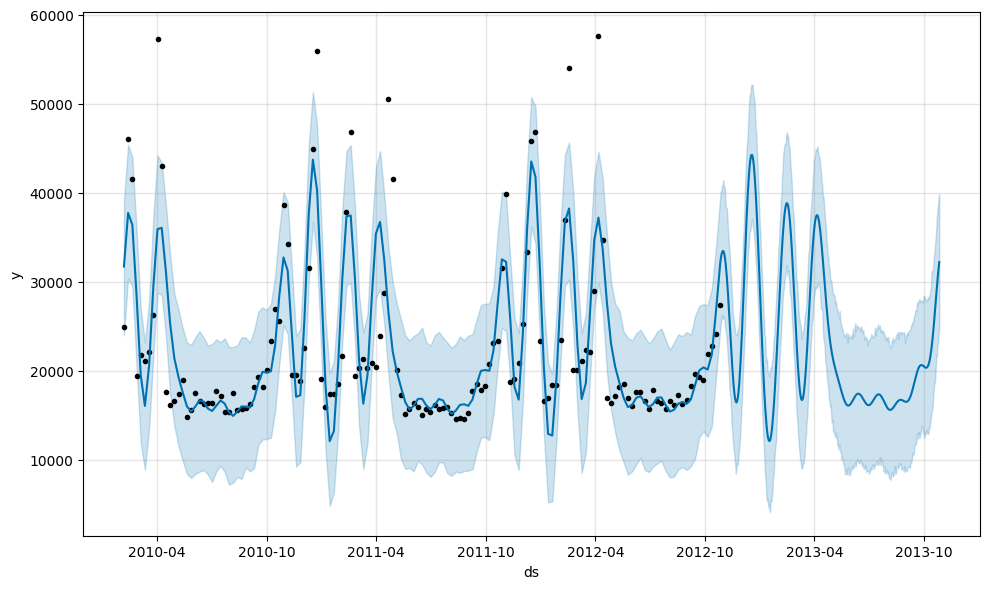

In [18]:
fig1 = m.plot(forecast)

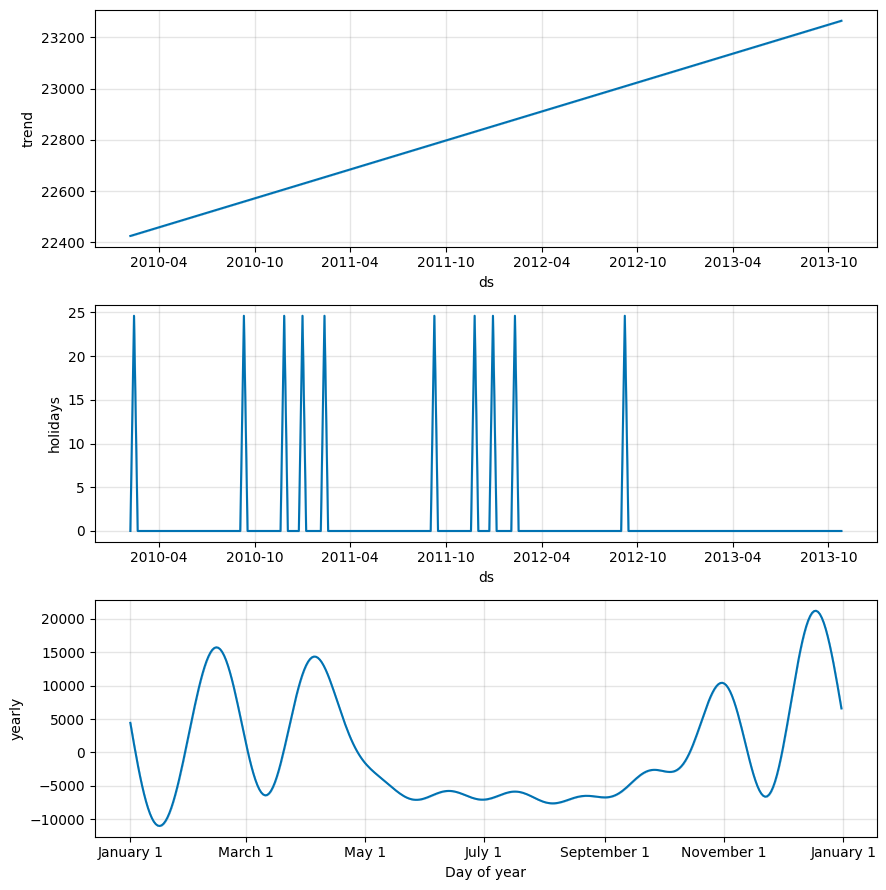

In [19]:
fig2 = m.plot_components(forecast)

In [20]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [21]:
plot_components_plotly(m, forecast)

/home/glegeza/Programming/semestr1/time-series-forecasting/venv/lib/python3.11/site-packages/prophet/plot.py:870: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [22]:
def try_prophet(store, dept):
    train_data = data[(data["Store"] == store) & (data["Dept"] == dept)][["Date", "Weekly_Sales", "IsHoliday"]]
    train_data.columns = ["ds", "y", "h"]
    holidays = train_data.loc[train_data["h"]][["ds"]]
    holidays["holiday"] = "holiday"
    m = Prophet(holidays=holidays)
    m.fit(train_data)
    future = m.make_future_dataframe(periods=365)
    forecast = m.predict(future)
    fig1 = m.plot(forecast)
    fig2 = m.plot_components(forecast)

21:39:15 - cmdstanpy - INFO - Chain [1] start processing
21:39:15 - cmdstanpy - INFO - Chain [1] done processing


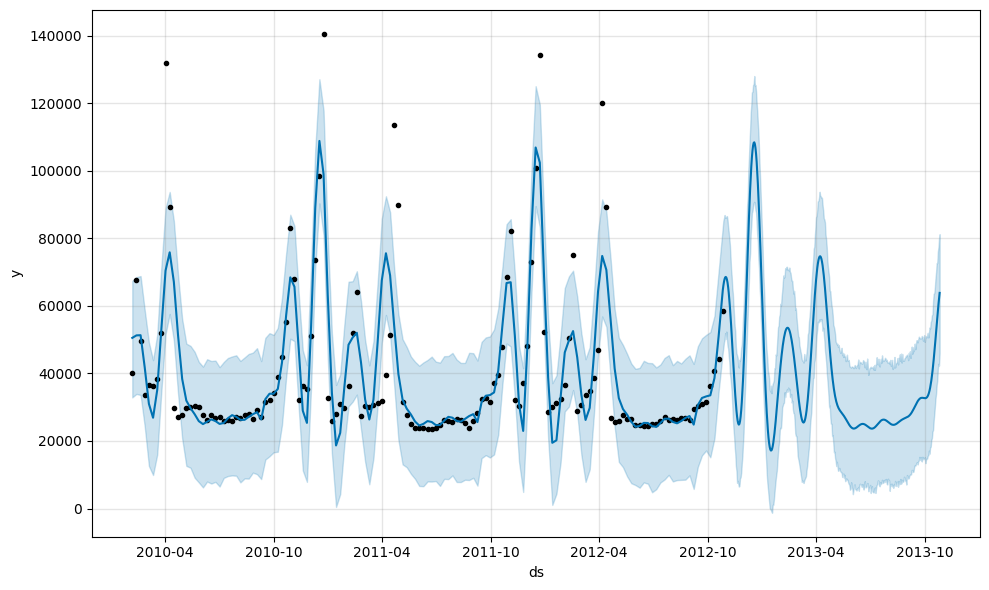

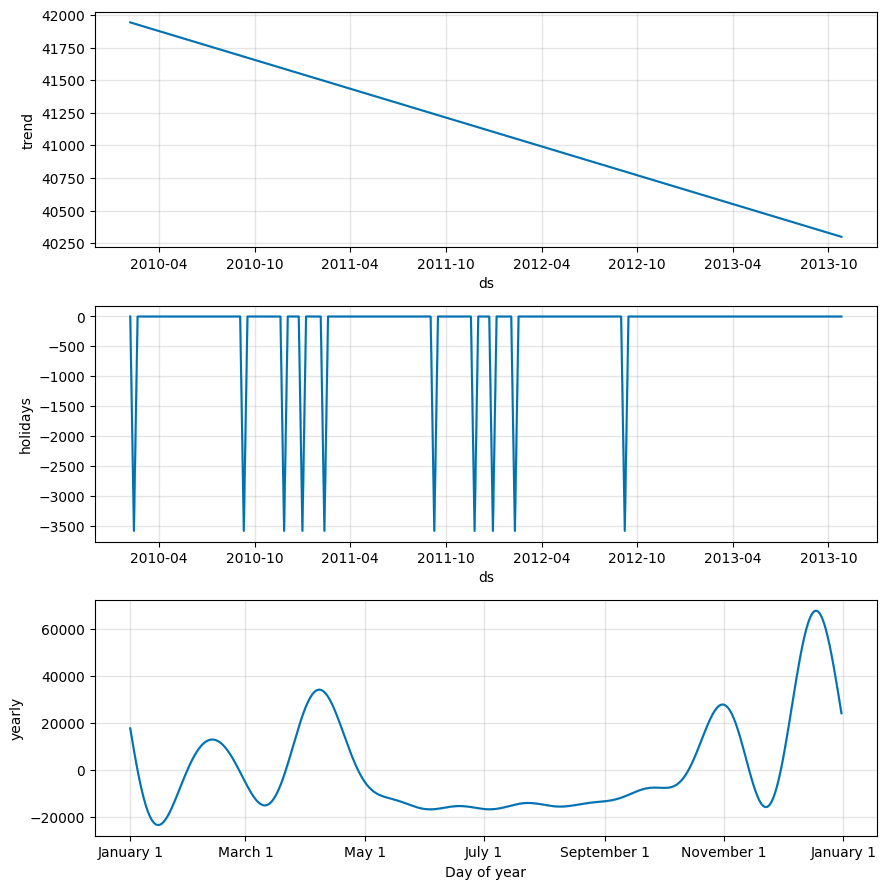

In [23]:
try_prophet(10, 1)